In [92]:
import glob, math, os, shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [5]:
! ls /home/jovyan/nas-dataset/JUPR/MAM20044/Bad/*.png | wc -l
! ls /home/jovyan/nas-dataset/JUPR/MAM20044/Good/*.png | wc -l
! ls /home/jovyan/nas-dataset/JUPR/888/*.jpg | wc -l

7
17763
104


In [114]:
class Result:
    def __init__(self, bImgFolder, gImgFolder, pdNpy, thresholdStategy="recall", imgExt="png"):
        bImgPathL, gImgPathL = sorted( glob.glob(f"{bImgFolder}/*.{imgExt}") ), sorted( glob.glob(f"{gImgFolder}/*.{imgExt}") )
        self.imgPathL  = bImgPathL + gImgPathL
        self.gtL       = [0]*len(bImgPathL) + [1]*len(gImgPathL)
        self.pdL       = np.load( pdNpy )
        self.precisionL, self.recallL, self.fvalueL = self.getPRF()
        self.bestThreshold = self.getBestThreshold(strategy=thresholdStategy)
        self.outputPath= os.path.abspath( pdNpy+"/../" )
        
    def getPRF(self):
        sigmoid = lambda z: 1/(1+math.e**(-z)) if z>-750 else 0
        precisionL, recallL, fvalueL = [], [], []
        for threshold in range(101):
            M = np.zeros((2,2))
            for i,score in zip(self.gtL, self.pdL):
                j = int(sigmoid(score)>=0.01*threshold)
                M[i][j]+=1
            precisionL.append( M[0][0]/M[0,:].sum() if M[0,:].sum()!=0 else 0 ) 
            recallL.append(    M[0][0]/M[:,0].sum() if M[:,0].sum()!=0 else 0 )
            fvalueL.append(    2*precisionL[-1]*recallL[-1]/(precisionL[-1]+recallL[-1]) if precisionL[-1]+recallL[-1] else 0 )
        #print( [ (i*0.01,round(precisionL[i*10],3),round(recallL[i*10],3)) for i in range(10) ] )
        return precisionL, recallL, fvalueL
    
    def plotPR(self):
        refineRecallL = self.recallL[:]
        for i in range(1,101):
            refineRecallL[-1-i] = max(refineRecallL[-1-i], refineRecallL[-i])
        plt.figure(figsize=(6*2,4))
        plt.subplot(1,2,1)
        plt.plot(self.precisionL)
        plt.plot(self.recallL)
        plt.plot(self.fvalueL)
        plt.grid('on')
        plt.legend(labels=["precision","recall","fvalue"])
        plt.xlabel("threshold", fontsize=16)
        plt.subplot(1,2,2)
        plt.title("PR-curve", fontsize=16)
        plt.plot(refineRecallL, self.precisionL)
        plt.scatter(refineRecallL, self.precisionL)
        plt.grid('on')
        plt.show()
    
    def getBestThreshold(self, strategy):
        if strategy=="precision":
            maxp = max( p for p,r in zip(self.precisionL,self.recallL) if r>0.5 )
            idxL = [ i for i in range(101) if self.precisionL[i]==maxp ]
        elif strategy=="recall":            
            maxr = max( r for p,r in zip(self.precisionL,self.recallL) if p>0.5 )
            idxL = [ i for i in range(101) if self.recallL[i]==maxr ]
        elif strategy=="fvalue":
            maxf = max(fvalueL)
            idxL = [ i for i in range(101) if self.fvalueL[i]==maxf ]
        else:
            raise
        return idxL[len(idxL)//2] * 0.01 # get middle threhold since max value can correspond to multiple thre 
        
    def plotConfusion(self):
        # collect confusion matrix path self.pathM
        sigmoid = lambda z: 1/(1+math.e**(-z)) if z>-750 else 0
        self.pathM = [[[],[]], [[],[]]] # self.pathM[0][0]: path of TP
        for i,score,imgPath in zip(self.gtL, self.pdL, self.imgPathL):
            j = int(sigmoid(score)>self.bestThreshold)
            self.pathM[i][j].append( imgPath )
        
        # confusion matrix M
        M = np.array( [ len(self.pathM[i][j]) for i in range(2) for j in range(2) ] ).reshape(2,2)
        # print("confusion_matrix:\n", M)
        axis0sum = M.sum(axis=0)
        N = M.copy().astype(np.float)
        for i in range(len(N)):
            if axis0sum[i] != 0:
                N[:,i] /= axis0sum[i]
        axis1sum = M.sum(axis=1)
        P = M.copy().astype(np.float)
        for i in range(len(P)):
            if axis1sum[i] != 0:
                P[i,:] /= axis1sum[i]
        plt.figure(figsize=(5*3,4))
        # fig1 - number
        fig = plt.subplot(1,3,1)
        plt.title(f"Confusion Matrix - Number (conf={0.5})", fontsize=12)
        plt.xlabel("GT", fontsize=12)
        plt.ylabel("PD", fontsize=12)
        fig.set_xticks([0,1]) # values
        fig.set_xticklabels(['BAD','GOOD']) # labels
        fig.set_yticks([0,1]) # values
        fig.set_yticklabels(['BAD','GOOD']) # labels
        plt.imshow(P, cmap=mpl.cm.Blues, interpolation='nearest', vmin=0, vmax=1)
        for i in range(2):
            for j in range(2):
                plt.text(j, i, int(M[i][j]), ha="center", va="center", color="black" if P[i][j]<0.9 else "white", fontsize=12)
        # fig2 - precision
        fig = plt.subplot(1,3,2)
        plt.title(f"Confusion Matrix - Row norm (Precision)", fontsize=12)
        plt.xlabel("GT", fontsize=12)
        plt.ylabel("PD", fontsize=12)
        fig.set_xticks([0,1]) # values
        fig.set_xticklabels(['BAD','GOOD']) # labels
        fig.set_yticks([0,1]) # values
        fig.set_yticklabels(['BAD','GOOD']) # labels
        plt.imshow(P, cmap=mpl.cm.Blues, interpolation='nearest', vmin=0, vmax=1)
        for i in range(2):
            for j in range(2):
                plt.text(j, i, round(P[i][j],3), ha="center", va="center", color="black" if P[i][j]<0.9 else "white", fontsize=12)
        # fig3 - recall
        fig = plt.subplot(1,3,3)
        plt.title(f"Confusion Matrix - Col norm (Recall)", fontsize=12)
        plt.xlabel("GT", fontsize=12)
        plt.ylabel("PD", fontsize=12)
        fig.set_xticks([0,1]) # values
        fig.set_xticklabels(['BAD','GOOD']) # labels
        fig.set_yticks([0,1]) # values
        fig.set_yticklabels(['BAD','GOOD']) # labels
        plt.imshow(N, cmap=mpl.cm.Blues, interpolation='nearest', vmin=0, vmax=1)
        for i in range(2):
            for j in range(2):
                plt.text(j, i, round(N[i][j],3), ha="center", va="center", color="black" if N[i][j]<0.9 else "white", fontsize=12)
        #plt.colorbar(mpl.cm.ScalarMappable(cmap=mpl.cm.Blues))
        plt.savefig(f"{self.outputPath}/confusion.jpg")
        plt.show()
        
    def getWrong(self):
        os.makedirs( f"{self.outputPath}/GT_G_PD_B", exist_ok=True ) # FN # -recall
        for path in self.pathM[0][1]:
            shutil.copy(path, f"{self.outputPath}/GT_G_BD_B/{ os.path.basename(path) }")
        os.makedirs( f"{self.outputPath}/GT_B_PD_G", exist_ok=True ) # FP # -precision
        for path in self.pathM[1][0]:
            shutil.copy(path, f"{self.outputPath}/GT_B_BD_G/{ os.path.basename(path) }")
        print( f"len(glob.glob({self.outputPath}/GT_G_BD_B/*.png'))=", len(glob.glob(f"{self.outputPath}/GT_G_BD_B/*.png")) )
        print( f"len(glob.glob({self.outputPath}/GT_B_BD_G/*.png'))=", len(glob.glob(f"{self.outputPath}/GT_G_BD_B/*.png")) )

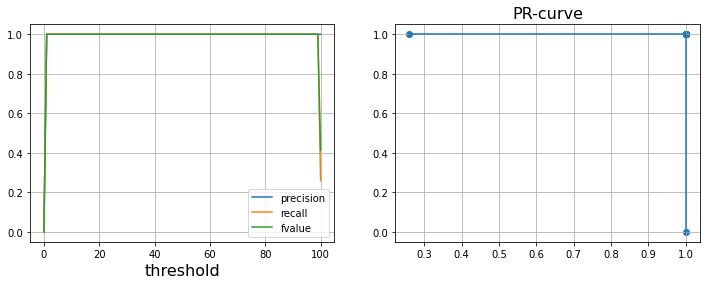

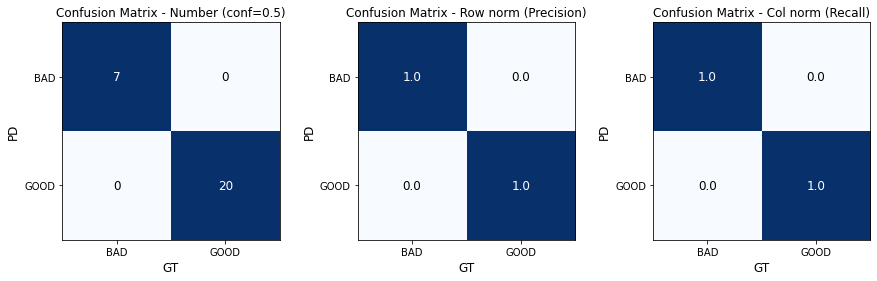

len(glob.glob(/home/jovyan/data-vol-1/Transformaly/experiments/multimodal/cats_vs_dogs_mam_v1/class_0/model/GT_G_BD_B/*.png'))= 0
len(glob.glob(/home/jovyan/data-vol-1/Transformaly/experiments/multimodal/cats_vs_dogs_mam_v1/class_0/model/GT_B_BD_G/*.png'))= 0


In [104]:
obj = Result(bImgFolder="../_data/mam/eval/bad", gImgFolder="../_data/mam/eval/good", \
             pdNpy="../experiments/multimodal/cats_vs_dogs_mam_v1/class_0/model/o_test_finetuned_samples_likelihood.npy")
obj.plotPR()
obj.plotConfusion()
obj.getWrong()

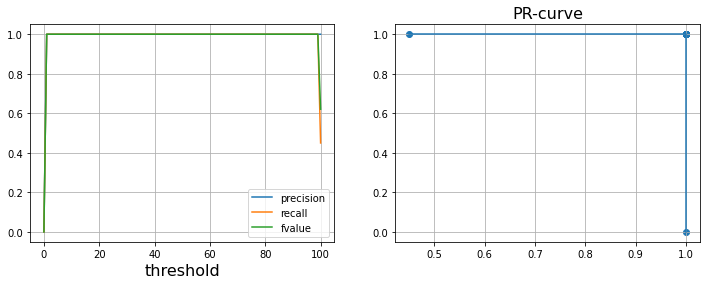

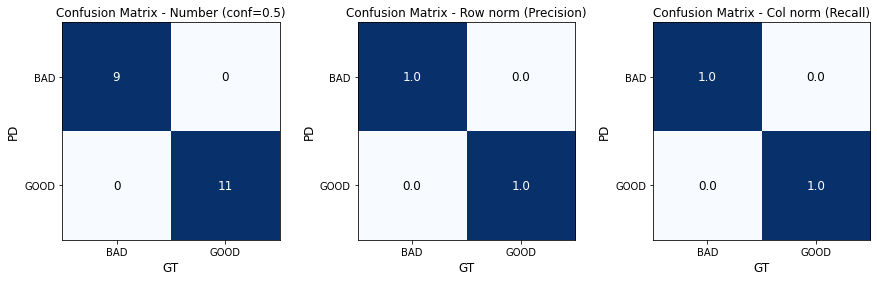

len(glob.glob(/home/jovyan/data-vol-1/Transformaly/experiments/multimodal/cats_vs_dogs_888_v0/class_0/model/GT_G_BD_B/*.png'))= 0
len(glob.glob(/home/jovyan/data-vol-1/Transformaly/experiments/multimodal/cats_vs_dogs_888_v0/class_0/model/GT_B_BD_G/*.png'))= 0


In [117]:
obj = Result(bImgFolder="../_data/888_v0/eval/bad", gImgFolder="../_data/888_v0/eval/good", \
             pdNpy="../experiments/multimodal/cats_vs_dogs_888_v0/class_0/model/o_test_finetuned_samples_likelihood.npy", imgExt="jpg")
obj.plotPR()
obj.plotConfusion()
obj.getWrong()